# Variant effect prediction analysis


In [1]:
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
from scipy.stats import chi2

sns.set_style("white")
sns.set_context("paper", font_scale=1.0)
sns.set_palette(sns.color_palette("rocket"))


In [2]:
lead_variant_maf_dataset = pl.read_parquet("../../lead_variant_maf.parquet")


In [3]:
lead_variant_maf_dataset.shape


(2622098, 18)

In [4]:
lead_variant_maf_dataset.head()


studyId,studyLocusId,variantId,beta,zScore,pValueMantissa,pValueExponent,standardError,finemappingMethod,studyType,credibleSetSize,nCases,nControls,nSamples,majorPopulation,majorPopulationMAF,majorPopulationAlleleFrequency,vepEffect
str,str,str,f64,f64,f32,i32,f64,str,str,i64,i32,i32,i32,struct[2],f64,list[struct[2]],struct[3]
"""gtex_txrev_prostate_ensg000001…","""9cf8bb4583ab369310742a50dee370…","""13_45342674_C_T""",-1.21864,null,4.021,-7,0.232593,"""SuSie""","""tuqtl""",30,null,null,218,"{""nfe"",0.0}",0.000559,"[{""nfe_adj"",0.000559}]","{""intron_variant"",0.1,null}"
"""schmiedel_2018_tx_th2_memory_e…","""998d6b254b25f87d2b500e587ad60b…","""13_45342825_C_T""",1.6927,null,4.536,-11,0.219494,"""SuSie""","""eqtl""",31,null,null,89,"{""nfe"",0.0}",0.112651,"[{""nfe_adj"",0.112651}]","{""intron_variant"",0.1,null}"
"""gtex_txrev_uterus_ensg00000170…","""4666d5e4fb13431c5937e45720730e…","""13_45343039_A_T""",0.935377,null,1.71,-7,0.167887,"""SuSie""","""tuqtl""",22,null,null,129,"{""nfe"",0.0}",0.112192,"[{""nfe_adj"",0.112192}]","{""intron_variant"",0.1,null}"
"""gtex_txrev_muscle_ensg00000170…","""26633dba587823b0add355f3e67881…","""13_45343765_C_T""",0.521832,null,2.387,-4,0.141282,"""SuSie""","""tuqtl""",8,null,null,702,"{""nfe"",0.0}",0.020081,"[{""nfe_adj"",0.020081}]","{""intron_variant"",0.1,null}"
"""phlips_exon_ipsc_ensg000001709…","""bece5b71efb8e16685c1318cac9864…","""13_45344247_T_TTTTTA""",-0.67395,null,8.559,-6,0.139961,"""SuSie""","""eqtl""",1,null,null,83,"{""nfe"",0.0}",0.369299,"[{""nfe_adj"",0.630701}]","{""intron_variant"",0.1,null}"


In [5]:
# NOTE! Calculate variance explained requires removal of the studies that have nSamples = 0
df = (
    lead_variant_maf_dataset.filter(pl.col("nSamples").is_not_null())
    .select(
        "*",
        (pl.col("pValueMantissa") * 10).pow(pl.col("pValueExponent")).alias("pValue"),
        (pl.col("pValueMantissa") * 10)
        .pow(pl.col("pValueExponent").map_elements(lambda x: chi2.cdf(x, 1), pl.Float64()))
        .alias("cdf"),
    )
    .select(
        "*",
        (pl.col("cdf") / pl.col("nSamples")).alias("varianceExplained"),
    )
)


## Plots

MAF vs size of credible set

In [42]:
def plot_maf_vs_cs_size(data: pl.DataFrame, ax):
    assert "majorPopulationMAF" in data.columns
    assert "credibleSetSize" in data.columns
    data = data.select(pl.col("majorPopulationMAF"), pl.col("credibleSetSize"))
    return sns.scatterplot(
        data=data,
        x="majorPopulationMAF",
        y="credibleSetSize",
        ax=ax,
        alpha=0.05,
        # line_kws=dict(color="r"),
    )


def plot_maf_vs_cs_size_weighted(data: pl.DataFrame):
    assert "majorPopulationMAF" in data.columns
    assert "credibleSetSize" in data.columns
    data = (
        data.select(pl.col("majorPopulationMAF"), pl.col("credibleSetSize"))
        .group_by("majorPopulationMAF", "credibleSetSize")
        .len()
        .select("majorPopulationMAF", "credibleSetSize", pl.col("len").alias("weight"))
    )
    return sns.relplot(
        data=data,
        x="majorPopulationMAF",
        y="credibleSetSize",
        size="weight",
        # alpha=0.05,
        sizes=(1, 100),
        # line_kws=dict(color="r"),
    )


def plot_af_vs_cs_size(data: pl.DataFrame, ax):
    assert "credibleSetSize" in data.columns
    assert "majorPopulationAlleleFrequency" in data.columns
    data = data.select(
        pl.col("majorPopulationAlleleFrequency")
        .list.first()
        .struct.field("alleleFrequency")
        .alias("majorPopulationAF"),
        pl.col("credibleSetSize"),
    )
    # print(data.schema)
    return sns.scatterplot(
        data=data,
        x="majorPopulationAF",
        y="credibleSetSize",
        ax=ax,
        alpha=0.05,
        # line_kws=dict(color="r"),
    )


def plot_n_vs_cs_size(data: pl.DataFrame, ax):
    assert "nSamples" in data.columns
    assert "credibleSetSize" in data.columns
    data = data.select(pl.col("nSamples"), pl.col("credibleSetSize"))
    return sns.scatterplot(
        data=data,
        x="nSamples",
        y="credibleSetSize",
        ax=ax,
        alpha=0.05,
        # line_kws=dict(color="r"),
    )


def plot_var_vs_cs_size(data: pl.DataFrame, ax):
    assert "varianceExplained" in data.columns
    assert "credibleSetSize" in data.columns
    data = data.select(pl.col("varianceExplained"), pl.col("credibleSetSize"))
    return sns.scatterplot(
        data=data,
        x="varianceExplained",
        y="credibleSetSize",
        ax=ax,
        # alpha=0.05,
        # line_kws=dict(color="r"),
    )


def plot_var_vs_MAF(data: pl.DataFrame, ax):
    assert "varianceExplained" in data.columns
    assert "majorPopulationMAF" in data.columns
    data = data.select(pl.col("varianceExplained"), pl.col("majorPopulationMAF"))
    return sns.scatterplot(
        data=data,
        y="varianceExplained",
        x="majorPopulationMAF",
        ax=ax,
        # alpha=0.05,
        # line_kws=dict(color="r"),
    )


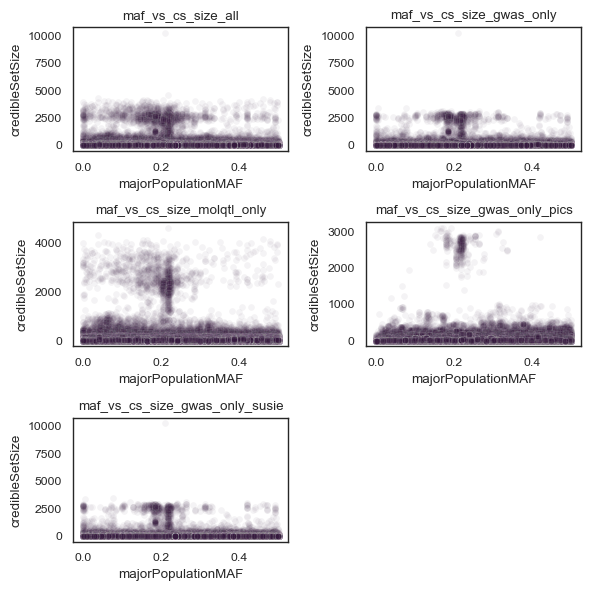

In [113]:
data = df
data2 = df.filter(pl.col("studyType") == "gwas")
data3 = df.filter(pl.col("studyType") != "gwas")
data4 = df.filter(pl.col("studyType") == "gwas").filter(pl.col("finemappingMethod") == "PICS")
data5 = df.filter(pl.col("studyType") == "gwas").filter(pl.col("finemappingMethod") != "PICS")

fig = plt.figure(figsize=(6, 6))
ax1 = plt.subplot(3, 2, 1)
ax2 = plt.subplot(3, 2, 2)
ax3 = plt.subplot(3, 2, 3)
ax4 = plt.subplot(3, 2, 4)
ax5 = plt.subplot(3, 2, 5)
plot_maf_vs_cs_size(data, ax1).set_title("maf_vs_cs_size_all")
plot_maf_vs_cs_size(data2, ax2).set_title("maf_vs_cs_size_gwas_only")
plot_maf_vs_cs_size(data3, ax3).set_title("maf_vs_cs_size_molqtl_only")
plot_maf_vs_cs_size(data4, ax4).set_title("maf_vs_cs_size_gwas_only_pics")
plot_maf_vs_cs_size(data5, ax5).set_title("maf_vs_cs_size_gwas_only_susie")
fig.tight_layout()

plt.show()


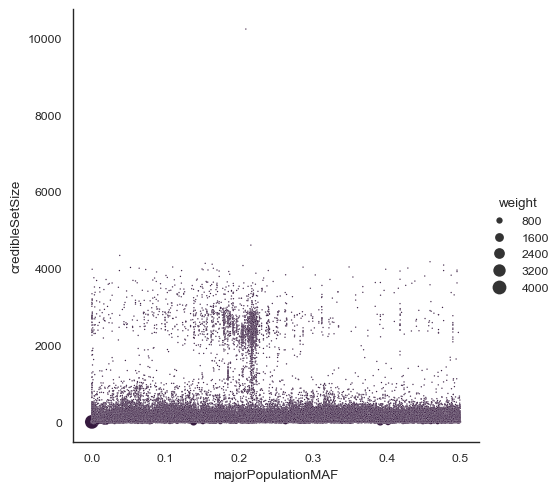

In [21]:
data = df
plot_maf_vs_cs_size_weighted(data)
plt.show()


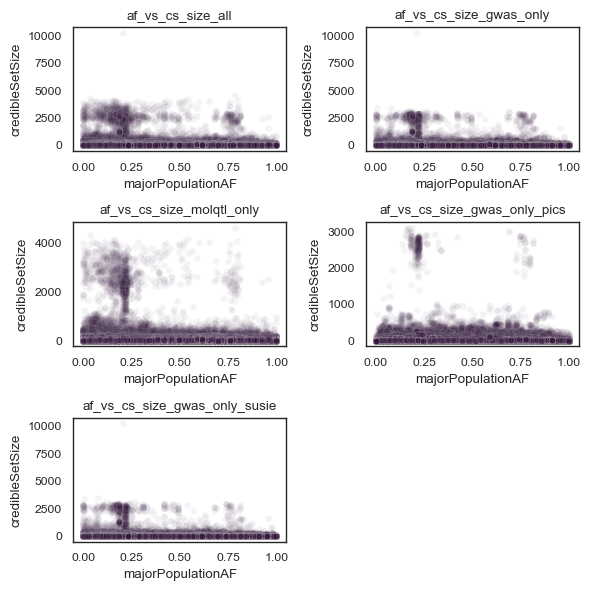

In [114]:
data = df
data2 = df.filter(pl.col("studyType") == "gwas")
data3 = df.filter(pl.col("studyType") != "gwas")
data4 = df.filter(pl.col("studyType") == "gwas").filter(pl.col("finemappingMethod") == "PICS")
data5 = df.filter(pl.col("studyType") == "gwas").filter(pl.col("finemappingMethod") != "PICS")

fig = plt.figure(figsize=(6, 6))
ax1 = plt.subplot(3, 2, 1)
ax2 = plt.subplot(3, 2, 2)
ax3 = plt.subplot(3, 2, 3)
ax4 = plt.subplot(3, 2, 4)
ax5 = plt.subplot(3, 2, 5)
plot_af_vs_cs_size(data, ax1).set_title("af_vs_cs_size_all")
plot_af_vs_cs_size(data2, ax2).set_title("af_vs_cs_size_gwas_only")
plot_af_vs_cs_size(data3, ax3).set_title("af_vs_cs_size_molqtl_only")
plot_af_vs_cs_size(data4, ax4).set_title("af_vs_cs_size_gwas_only_pics")
plot_af_vs_cs_size(data5, ax5).set_title("af_vs_cs_size_gwas_only_susie")
fig.tight_layout()

plt.show()


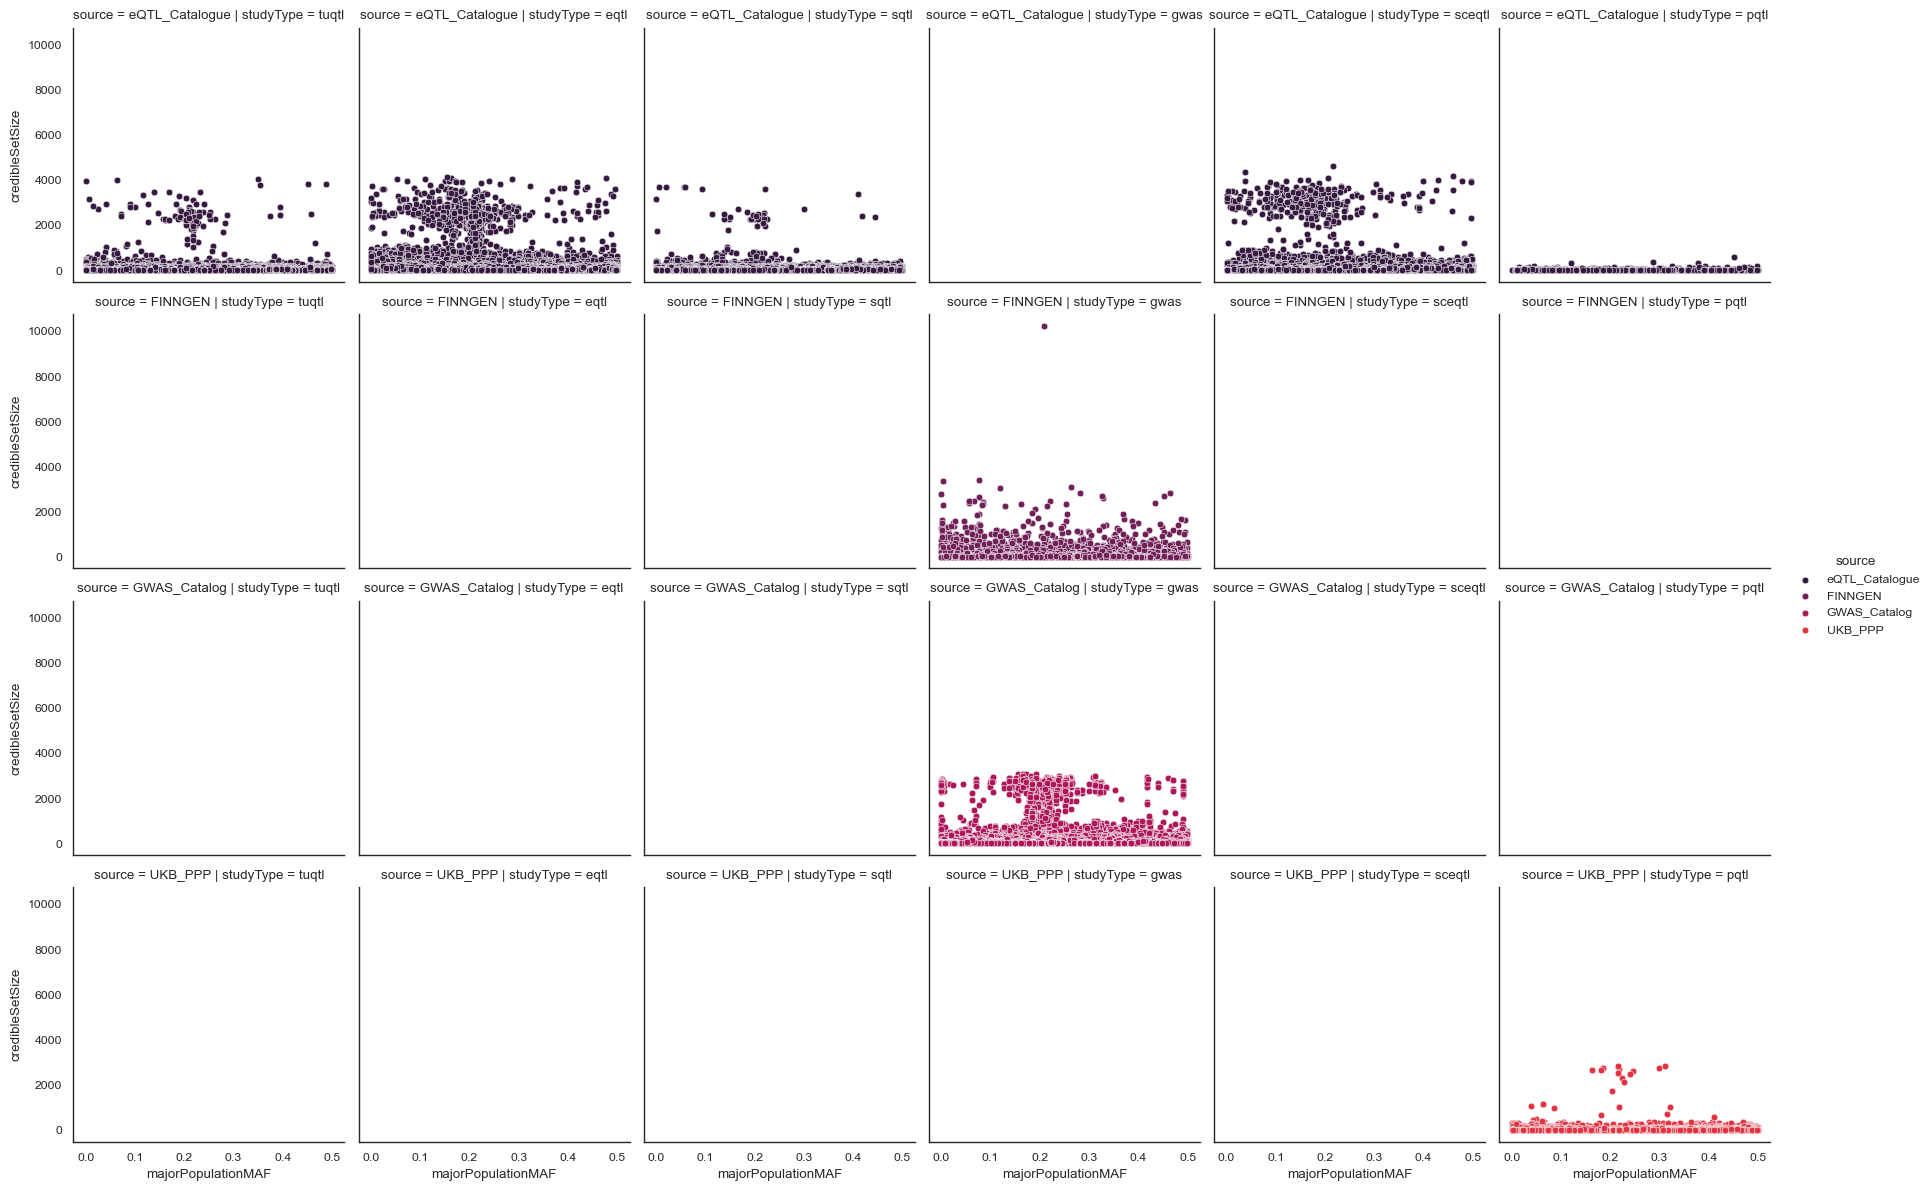

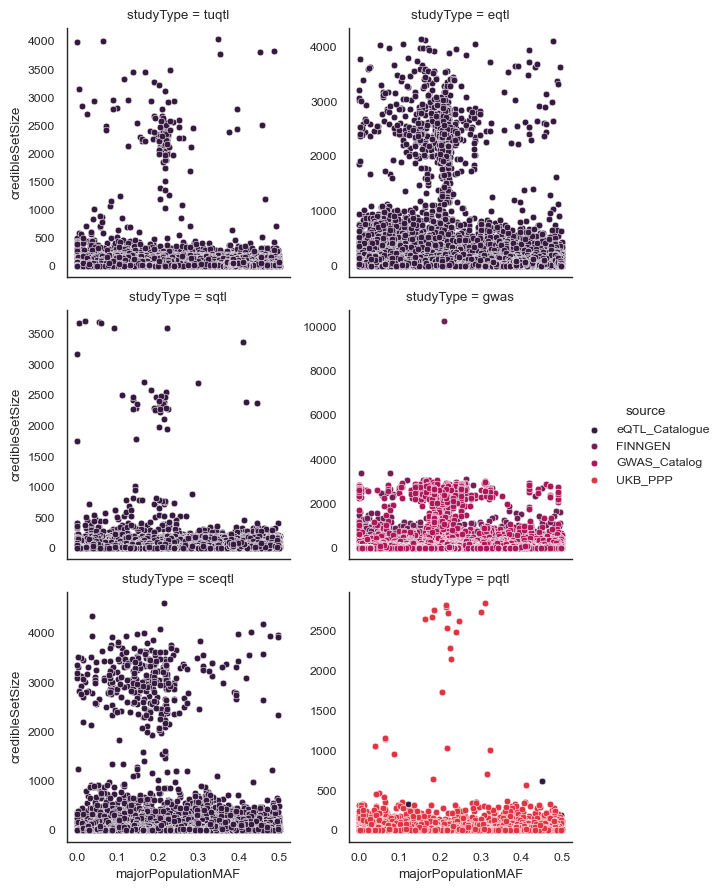

In [115]:
_data = df.select(
    "majorPopulationMAF",
    "credibleSetSize",
    "studyType",
    "studyId",
    pl.when(pl.col("studyId").str.starts_with("GCST"))
    .then(pl.lit("GWAS_Catalog"))
    .when(pl.col("studyId").str.starts_with("FINNGEN"))
    .then(pl.lit("FINNGEN"))
    .when(pl.col("studyId").str.starts_with("UKB"))
    .then(pl.lit("UKB_PPP"))
    .otherwise(pl.lit("eQTL_Catalogue"))
    .alias("source"),
)
g = sns.FacetGrid(_data, col="studyType", row="source", hue="source")
g.map(sns.scatterplot, "majorPopulationMAF", "credibleSetSize")
g.add_legend()

g2 = sns.FacetGrid(_data, col="studyType", hue="source", col_wrap=2, sharey=False)
g2.map(
    sns.scatterplot,
    "majorPopulationMAF",
    "credibleSetSize",
)
g2.add_legend()

plt.show()


## Sample size vs credible set size

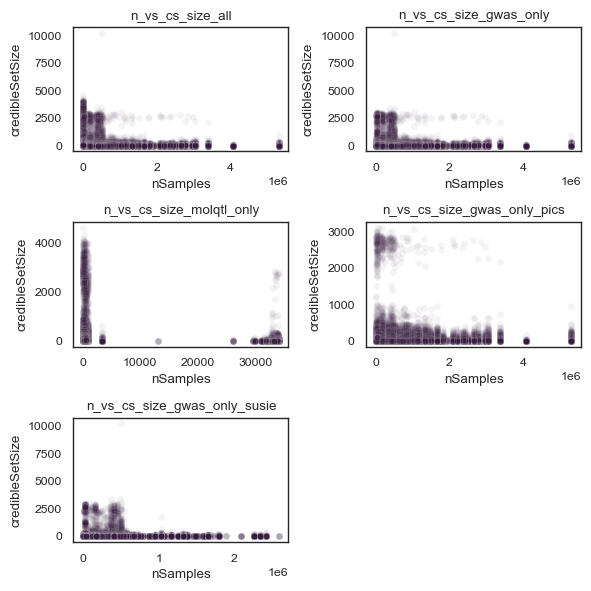

In [116]:
data = df
data2 = df.filter(pl.col("studyType") == "gwas")
data3 = df.filter(pl.col("studyType") != "gwas")
data4 = df.filter(pl.col("studyType") == "gwas").filter(pl.col("finemappingMethod") == "PICS")
data5 = df.filter(pl.col("studyType") == "gwas").filter(pl.col("finemappingMethod") != "PICS")

fig = plt.figure(figsize=(6, 6))
ax1 = plt.subplot(3, 2, 1)
ax2 = plt.subplot(3, 2, 2)
ax3 = plt.subplot(3, 2, 3)
ax4 = plt.subplot(3, 2, 4)
ax5 = plt.subplot(3, 2, 5)
plot_n_vs_cs_size(data, ax1).set_title("n_vs_cs_size_all")
plot_n_vs_cs_size(data2, ax2).set_title("n_vs_cs_size_gwas_only")
plot_n_vs_cs_size(data3, ax3).set_title("n_vs_cs_size_molqtl_only")
plot_n_vs_cs_size(data4, ax4).set_title("n_vs_cs_size_gwas_only_pics")
plot_n_vs_cs_size(data5, ax5).set_title("n_vs_cs_size_gwas_only_susie")
fig.tight_layout()

plt.show()


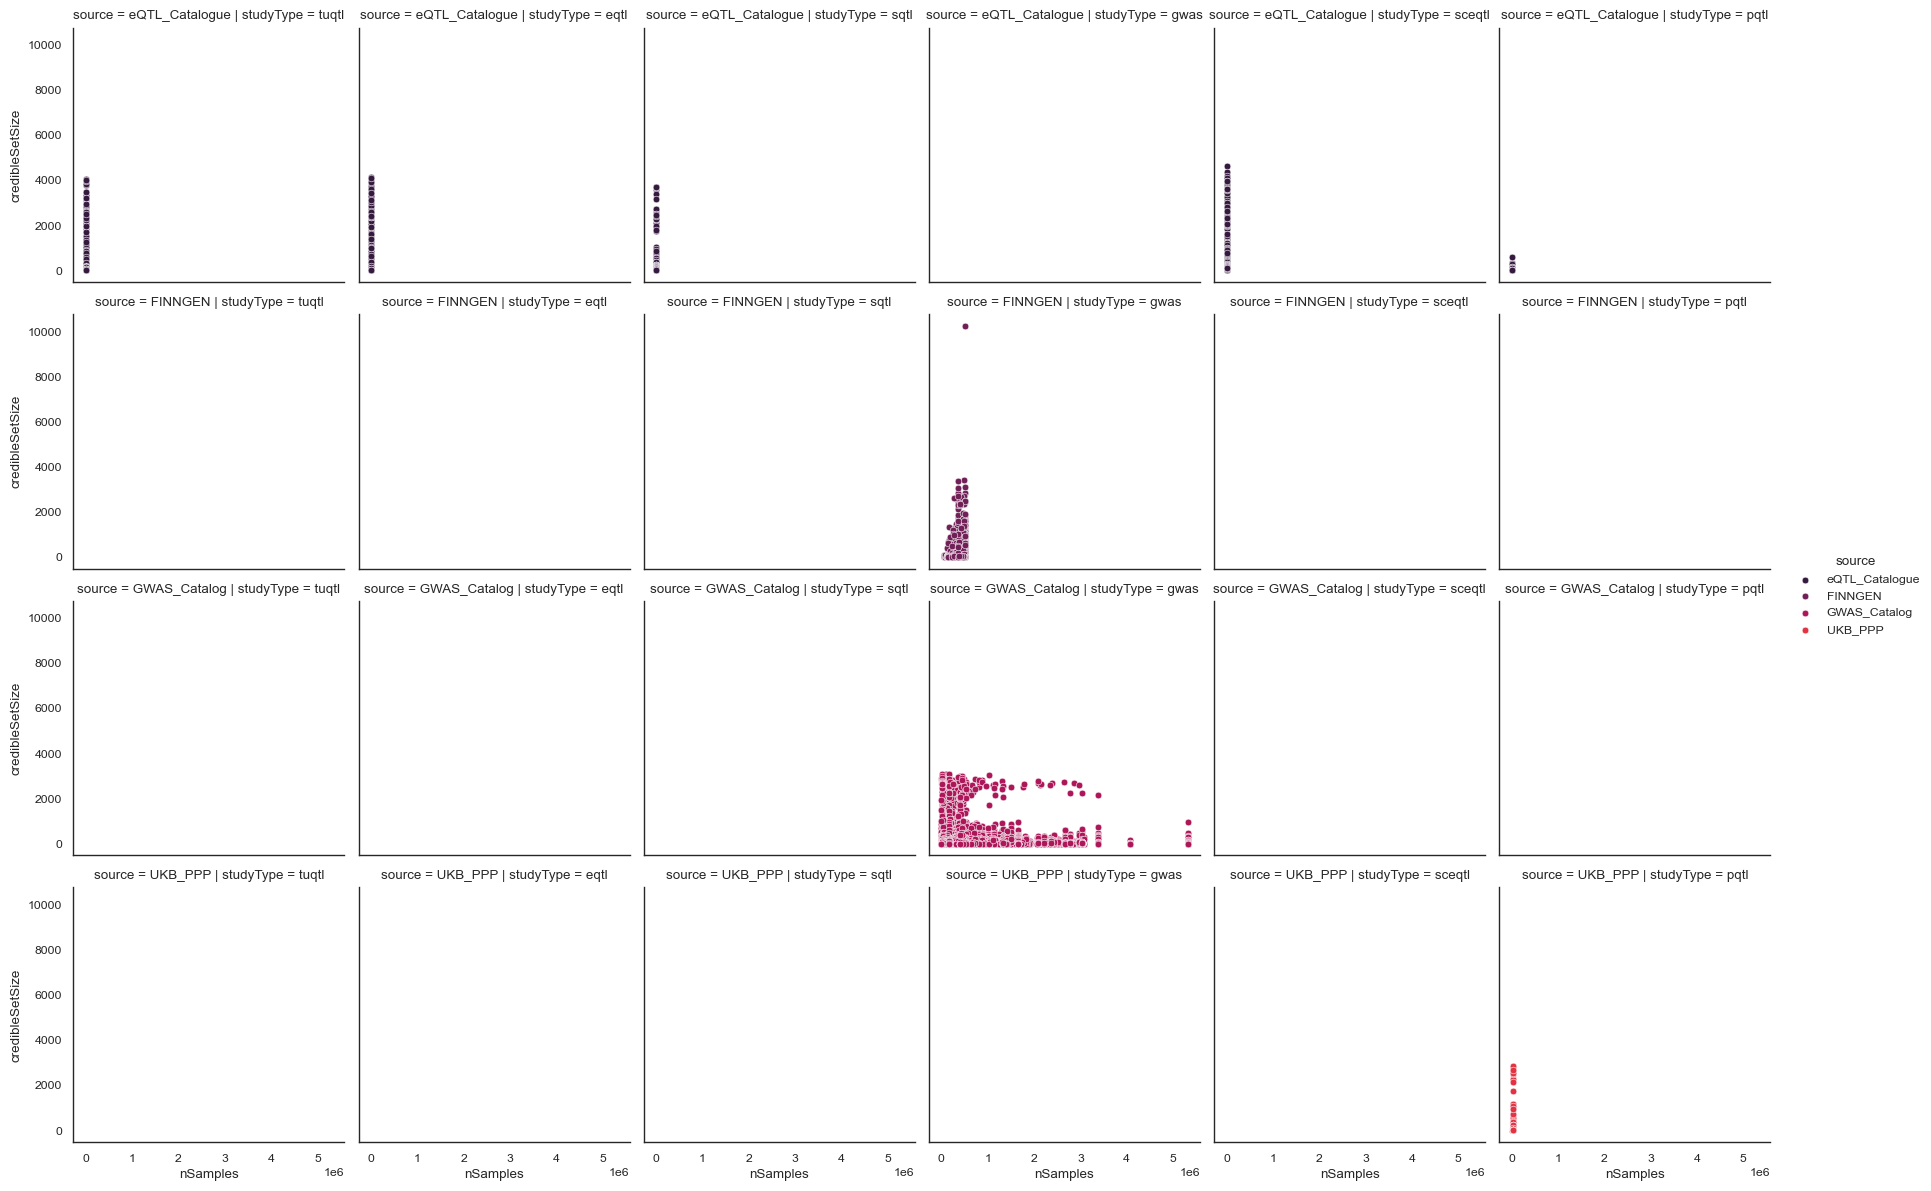

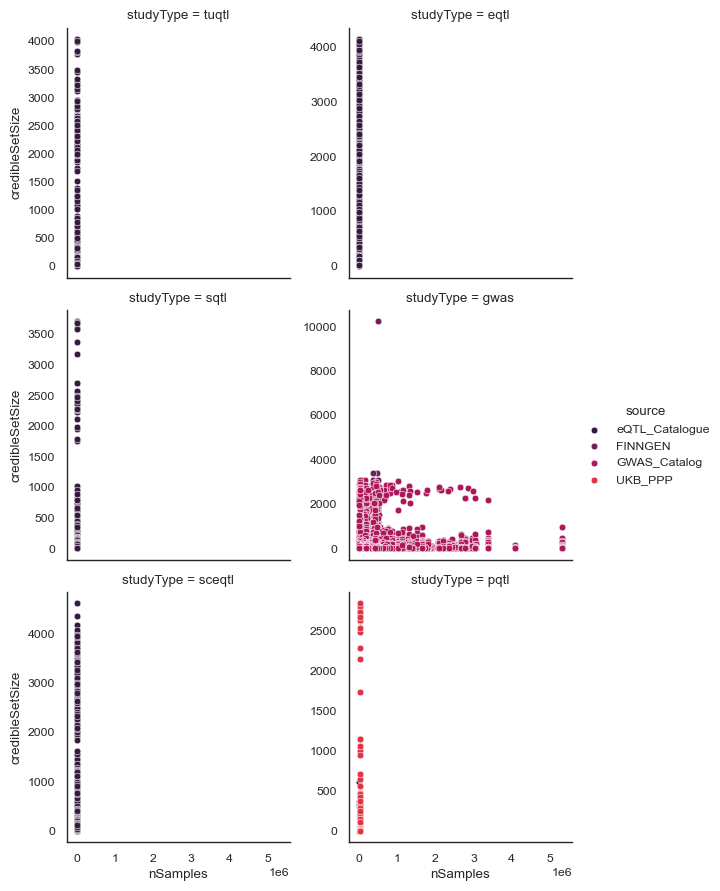

In [117]:
_data = df.select(
    "nSamples",
    "credibleSetSize",
    "studyType",
    "studyId",
    pl.when(pl.col("studyId").str.starts_with("GCST"))
    .then(pl.lit("GWAS_Catalog"))
    .when(pl.col("studyId").str.starts_with("FINNGEN"))
    .then(pl.lit("FINNGEN"))
    .when(pl.col("studyId").str.starts_with("UKB"))
    .then(pl.lit("UKB_PPP"))
    .otherwise(pl.lit("eQTL_Catalogue"))
    .alias("source"),
)
g = sns.FacetGrid(_data, col="studyType", row="source", hue="source")
g.map(sns.scatterplot, "nSamples", "credibleSetSize")
g.add_legend()

g2 = sns.FacetGrid(_data, col="studyType", hue="source", col_wrap=2, sharey=False)
g2.map(
    sns.scatterplot,
    "nSamples",
    "credibleSetSize",
)
g2.add_legend()

plt.show()


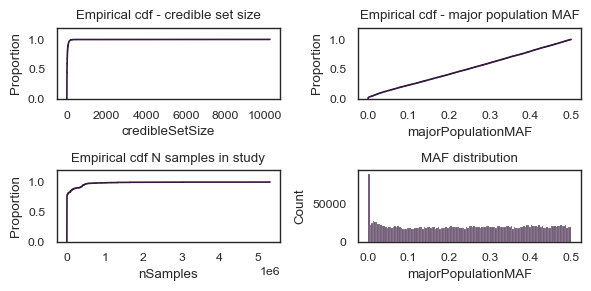

In [33]:
_data = df
fig2 = plt.figure(figsize=(6, 3))
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4)
sns.ecdfplot(data=_data.select("credibleSetSize"), x="credibleSetSize", ax=ax1)
ax1.set_title("Empirical cdf - credible set size")
ax1.set_ylim(ymax=1.2)
ax1.set_yticks([0.0, 0.5, 1.0])
# ax1.axhline(y=1.0, color="red", linestyle="--")

sns.ecdfplot(data=_data.select("majorPopulationMAF"), x="majorPopulationMAF", ax=ax2)
ax2.set_title("Empirical cdf - major population MAF")
ax2.set_ylim(ymax=1.2)
ax2.set_yticks([0.0, 0.5, 1.0])
sns.ecdfplot(data=_data.select("nSamples"), x="nSamples", ax=ax3)
ax3.set_title("Empirical cdf N samples in study")
ax3.set_ylim(ymax=1.2)
ax3.set_yticks([0.0, 0.5, 1.0])
sns.histplot(data=_data.select("majorPopulationMAF"), x="majorPopulationMAF", ax=ax4)
ax4.set_title("MAF distribution")
fig2.tight_layout()

plt.show()


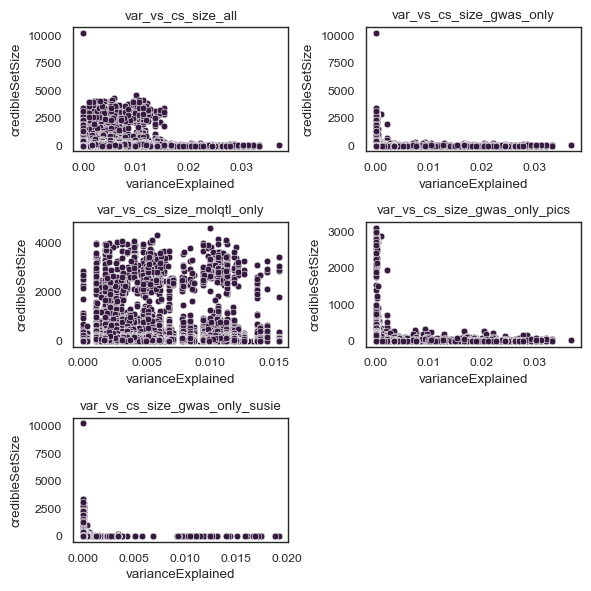

In [38]:
data = df
data2 = df.filter(pl.col("studyType") == "gwas")
data3 = df.filter(pl.col("studyType") != "gwas")
data4 = df.filter(pl.col("studyType") == "gwas").filter(pl.col("finemappingMethod") == "PICS")
data5 = df.filter(pl.col("studyType") == "gwas").filter(pl.col("finemappingMethod") != "PICS")

fig = plt.figure(figsize=(6, 6))
ax1 = plt.subplot(3, 2, 1)
ax2 = plt.subplot(3, 2, 2)
ax3 = plt.subplot(3, 2, 3)
ax4 = plt.subplot(3, 2, 4)
ax5 = plt.subplot(3, 2, 5)
plot_var_vs_cs_size(data, ax1).set_title("var_vs_cs_size_all")
plot_var_vs_cs_size(data2, ax2).set_title("var_vs_cs_size_gwas_only")
plot_var_vs_cs_size(data3, ax3).set_title("var_vs_cs_size_molqtl_only")
plot_var_vs_cs_size(data4, ax4).set_title("var_vs_cs_size_gwas_only_pics")
plot_var_vs_cs_size(data5, ax5).set_title("var_vs_cs_size_gwas_only_susie")
fig.tight_layout()

plt.show()


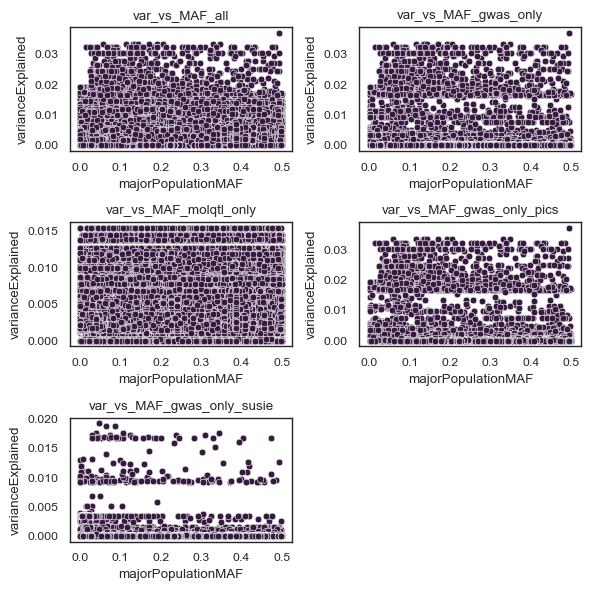

In [43]:
data = df
data2 = df.filter(pl.col("studyType") == "gwas")
data3 = df.filter(pl.col("studyType") != "gwas")
data4 = df.filter(pl.col("studyType") == "gwas").filter(pl.col("finemappingMethod") == "PICS")
data5 = df.filter(pl.col("studyType") == "gwas").filter(pl.col("finemappingMethod") != "PICS")

fig = plt.figure(figsize=(6, 6))
ax1 = plt.subplot(3, 2, 1)
ax2 = plt.subplot(3, 2, 2)
ax3 = plt.subplot(3, 2, 3)
ax4 = plt.subplot(3, 2, 4)
ax5 = plt.subplot(3, 2, 5)
plot_var_vs_MAF(data, ax1).set_title("var_vs_MAF_all")
plot_var_vs_MAF(data2, ax2).set_title("var_vs_MAF_gwas_only")
plot_var_vs_MAF(data3, ax3).set_title("var_vs_MAF_molqtl_only")
plot_var_vs_MAF(data4, ax4).set_title("var_vs_MAF_gwas_only_pics")
plot_var_vs_MAF(data5, ax5).set_title("var_vs_MAF_gwas_only_susie")
fig.tight_layout()

plt.show()
